In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download adarshrouniyar/air-pollution-image-dataset-from-india-and-nepal

100% 604M/605M [00:40<00:00, 17.5MB/s]
100% 605M/605M [00:40<00:00, 15.8MB/s]


In [ ]:
! unzip /content/air-pollution-image-dataset-from-india-and-nepal.zip

Streaming output truncated to the last 5000 lines.
  inflating: Air Pollution Image Dataset/Air Pollution Image Dataset/Country_wise_Dataset/India/Mumbai/c_Unhealthy_for_Sensitive_Groups/MH_UnFSG_2023-03-18-11.00-1-1.jpg  
  inflating: Air Pollution Image Dataset/Air Pollution Image Dataset/Country_wise_Dataset/India/Mumbai/c_Unhealthy_for_Sensitive_Groups/MH_UnFSG_2023-03-18-11.00-1-106.jpg  
  inflating: Air Pollution Image Dataset/Air Pollution Image Dataset/Country_wise_Dataset/India/Mumbai/c_Unhealthy_for_Sensitive_Groups/MH_UnFSG_2023-03-18-11.00-1-113.jpg  
  inflating: Air Pollution Image Dataset/Air Pollution Image Dataset/Country_wise_Dataset/India/Mumbai/c_Unhealthy_for_Sensitive_Groups/MH_UnFSG_2023-03-18-11.00-1-120.jpg  
  inflating: Air Pollution Image Dataset/Air Pollution Image Dataset/Country_wise_Dataset/India/Mumbai/c_Unhealthy_for_Sensitive_Groups/MH_UnFSG_2023-03-18-11.00-1-127.jpg  
  inflating: Air Pollution Image Dataset/Air Pollution Image Dataset/Country_wise

In [ ]:
import sys

import numpy as np

from typing import Dict, Optional, Tuple
from pathlib import Path

import math

import tensorflow as tf
from tensorflow import keras

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from tensorflow.keras import backend #Keras version 2.1.6
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Concatenate, LeakyReLU, Input, Conv2D, MaxPooling2D 

from tensorflow.keras import layers

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
#from PIL import Image

from sklearn.metrics import r2_score
from sklearn.utils import shuffle

%matplotlib inline

In [ ]:
import pandas as pd
df = pd.read_csv('/content/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/IND_and_Nep_AQI_Dataset.csv')
df.head()

,Location,Filename,Year,Month,Day,Hour,AQI,PM2.5,PM10,O3,CO,SO2,NO2,AQI_Class
0,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-9.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
1,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-8.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
2,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-7.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
3,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-6.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
4,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-5.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy


In [ ]:
np.random.seed(1)
nMax = 1000
res = df.groupby('AQI_Class').apply(lambda x: x.sample(n=min(nMax, len(x))))

print(res['AQI_Class'].value_counts())

a_Good                              1000
b_Moderate                          1000
c_Unhealthy_for_Sensitive_Groups    1000
d_Unhealthy                         1000
e_Very_Unhealthy                    1000
f_Severe                            1000
Name: AQI_Class, dtype: int64


In [ ]:
# df = shuffle(df)

# df.sample(frac=1).reset_index(drop=True)

number_of_rows = 6000
sub_dfs = [res[i:i + number_of_rows] for i in range(0, res.shape[0], number_of_rows)]
for idx, sub_df in enumerate(sub_dfs):
    sub_df.to_csv(f'frag3000_{idx}.csv', index=False)

In [ ]:
df = pd.read_csv('/content/frag3000_0.csv')
df.head(15)

,Location,Filename,Year,Month,Day,Hour,AQI,PM2.5,PM10,O3,CO,SO2,NO2,AQI_Class
0,Bengaluru,BENGR_Good_2023-02-27-08.30-1-406.jpg,2023,2,27,8:30,47,24.0,46.0,19.0,216.0,8.0,14.0,a_Good
1,Bengaluru,BENGR_Good_2023-02-28-08.30-1-341.jpg,2023,2,28,8:30,37,19.0,37.0,18.0,272.0,11.0,21.0,a_Good
2,Bengaluru,BENGR_Good_2023-02-26-08.30-1-226.jpg,2023,2,26,8:30,48,24.0,47.0,17.0,210.0,13.0,14.0,a_Good
3,Bengaluru,BENGR_Good_2023-02-28-08.30-1-441.jpg,2023,2,28,8:30,37,19.0,37.0,18.0,272.0,11.0,21.0,a_Good
4,Mumbai,MH_Good_2023-03-23-17.00-1-512.jpg,2023,3,23,17:00,47,14.0,41.0,35.0,6.0,5.0,7.0,a_Good
5,Mumbai,MH_Good_2023-03-22-11.00-1-36.jpg,2023,3,22,11:00,49,32.0,59.0,46.0,9.0,7.0,17.0,a_Good
6,Mumbai,MH_Good_2023-03-22-18.00-1-241.jpg,2023,3,22,18:00,47,21.0,43.0,37.0,4.0,8.0,7.0,a_Good
7,Tamil Nadu,TN_Good_2023-02-20-08.30-1-52.jpg,2023,2,20,8:30,37,37.0,28.0,22.0,1.0,22.0,5.0,a_Good
8,Bengaluru,BENGR_Good_2023-02-28-08.30-1-241.jpg,2023,2,28,8:30,37,19.0,37.0,18.0,272.0,11.0,21.0,a_Good
9,Tamil Nadu,TN_Good_2023-02-22-09.30-3-81.jpg,2023,2,22,9:30,36,18.0,28.0,8.0,346.0,27.0,7.0,a_Good


In [ ]:
def build_x(path):
    train_img = []
    for i in range(df.shape[0]):
        img = image.load_img(path + df['Filename'][i])
        img = image.img_to_array(img)
        img = tf.keras.applications.efficientnet_v2.preprocess_input(img)
        #img = img / 255        # with respect to imagenet, no scaling be used
        train_img.append(img)

    x = np.array(train_img)
    return x

In [ ]:
x_origin = build_x('/content/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/All_img/')

In [ ]:
x_origin.shape

(6000, 224, 224, 3)

In [ ]:
# pm25 = df
# pm25

,Location,Filename,Year,Month,Day,Hour,AQI,PM2.5,PM10,O3,CO,SO2,NO2,AQI_Class
0,Bengaluru,BENGR_Good_2023-02-27-08.30-1-406.jpg,2023,2,27,8:30,47,24.0,46.0,19.0,216.0,8.0,14.0,a_Good
1,Bengaluru,BENGR_Good_2023-02-28-08.30-1-341.jpg,2023,2,28,8:30,37,19.0,37.0,18.0,272.0,11.0,21.0,a_Good
2,Bengaluru,BENGR_Good_2023-02-26-08.30-1-226.jpg,2023,2,26,8:30,48,24.0,47.0,17.0,210.0,13.0,14.0,a_Good
3,Bengaluru,BENGR_Good_2023-02-28-08.30-1-441.jpg,2023,2,28,8:30,37,19.0,37.0,18.0,272.0,11.0,21.0,a_Good
4,Mumbai,MH_Good_2023-03-23-17.00-1-512.jpg,2023,3,23,17:00,47,14.0,41.0,35.0,6.0,5.0,7.0,a_Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,"ITO, Delhi",DEL_SEV_2023-02-20-14.00-1-446.jpg,2023,2,20,14:00,363,257.0,139.0,41.0,65.0,35.0,83.0,f_Severe
5996,"ITO, Delhi",DEL_SEV_2023-02-20-14.00-2-26.jpg,2023,2,20,14:00,363,257.0,139.0,41.0,65.0,35.0,83.0,f_Severe
5997,"ITO, Delhi",DEL_SEV_2023-02-20-14.00-3-106.jpg,2023,2,20,14:00,363,257.0,139.0,41.0,65.0,35.0,83.0,f_Severe
5998,"ITO, Delhi",DEL_SEV_2023-02-16-18.00-2-110.jpg,2023,2,16,18:00,330,418.0,357.0,12.0,106.0,7.0,119.0,f_Severe


In [ ]:
x_origin_train, x_origin_temp, y_train, y_temp = train_test_split(x_origin, df, train_size=0.8, shuffle=True, stratify=df['AQI_Class'])

In [ ]:
print(y_train['AQI_Class'].value_counts())

c_Unhealthy_for_Sensitive_Groups    800
e_Very_Unhealthy                    800
d_Unhealthy                         800
b_Moderate                          800
f_Severe                            800
a_Good                              800
Name: AQI_Class, dtype: int64


In [ ]:
x_origin_valid, x_origin_test, y_valid, y_test = train_test_split(x_origin_temp, y_temp, test_size=0.5, shuffle=True, stratify=y_temp['AQI_Class'])

In [ ]:
print(y_test['AQI_Class'].value_counts())
print(y_valid['AQI_Class'].value_counts())

f_Severe                            100
b_Moderate                          100
a_Good                              100
c_Unhealthy_for_Sensitive_Groups    100
d_Unhealthy                         100
e_Very_Unhealthy                    100
Name: AQI_Class, dtype: int64
a_Good                              100
b_Moderate                          100
d_Unhealthy                         100
c_Unhealthy_for_Sensitive_Groups    100
e_Very_Unhealthy                    100
f_Severe                            100
Name: AQI_Class, dtype: int64


In [ ]:
y_train = y_train['PM2.5']
y_temp = y_temp['PM2.5']
y_valid = y_valid['PM2.5']
y_test = y_test['PM2.5']

In [ ]:
x_origin_train.shape

(4800, 224, 224, 3)

In [ ]:
y_train.shape

(4800,)

In [ ]:
x_origin = []
x_origin_temp = []
y_temp = []
y = []

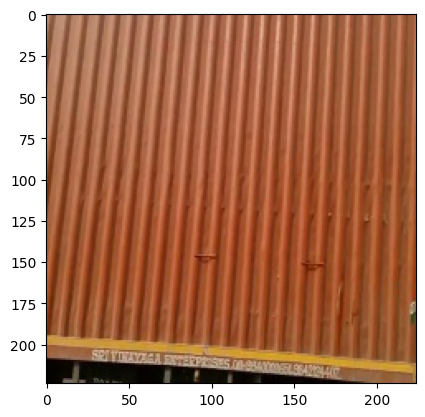

In [ ]:
plt.imshow(x_origin_test[10]/255)

In [ ]:
y_test = y_test.reset_index(drop=True)
y_test

0      257.00
1       29.00
2       20.00
3       34.00
4       30.27
        ...  
595     31.00
596    279.00
597     66.20
598     67.06
599     70.08
Name: PM2.5, Length: 600, dtype: float64

In [ ]:
y_test.head(15)

0     257.00
1      29.00
2      20.00
3      34.00
4      30.27
5     180.00
6      29.00
7      70.08
8     100.00
9      33.18
10     84.00
11     22.00
12    401.00
13    132.00
14    185.00
Name: PM2.5, dtype: float64

In [ ]:
pre_trained_model  = tf.keras.applications.EfficientNetV2S(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
for layer in pre_trained_model.layers:
    layer.trainable = False
    print(layer.name)

82420632/82420632 [==============================] - 6s 0us/step
input_1
rescaling
stem_conv
stem_bn
stem_activation
block1a_project_conv
block1a_project_bn
block1a_project_activation
block1a_add
block1b_project_conv
block1b_project_bn
block1b_project_activation
block1b_drop
block1b_add
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block2c_expand_conv
block2c_expand_bn
block2c_expand_activation
block2c_project_conv
block2c_project_bn
block2c_drop
block2c_add
block2d_expand_conv
block2d_expand_bn
block2d_expand_activation
block2d_project_conv
block2d_project_bn
block2d_drop
block2d_add
block3a_expand_conv
block3a_expand_bn
block3a_expand_activation
block3a_project_conv
block3a_project_bn
block3b_expand_conv
block3b_expand_bn
block3b_expand_activation
block3b_project_conv
block3b_project_bn
block3b_drop


In [ ]:
x1 = Flatten()(pre_trained_model.output)
fc1 = Dense(512, activation = 'relu')(x1)
fc2 = Dense(512, activation = 'relu')(fc1)
x = Dense(1, activation='linear')(fc2)
model = Model(pre_trained_model.input, x)
    
opt = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss='mse', optimizer=opt)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
weight_path="{}_aqi.best.h5".format('EfficientNetV2S')

In [ ]:
callback = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto'),
    ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                    save_best_only=True, mode='min', save_weights_only = True)]
history = model.fit(x=x_origin_train, y=y_train, validation_data=(x_origin_valid, y_valid), batch_size=16, epochs=150, callbacks=callback)

Epoch 1/150
300/300 [==============================] - ETA: 0s - loss: 5552.3657
Epoch 1: val_loss improved from inf to 3091.53345, saving model to EfficientNetV2S_aqi.best.h5
300/300 [==============================] - 59s 117ms/step - loss: 5552.3657 - val_loss: 3091.5334
Epoch 2/150
300/300 [==============================] - ETA: 0s - loss: 2148.1731
Epoch 2: val_loss did not improve from 3091.53345
300/300 [==============================] - 24s 81ms/step - loss: 2148.1731 - val_loss: 3160.1121
Epoch 3/150
300/300 [==============================] - ETA: 0s - loss: 1677.5181
Epoch 3: val_loss improved from 3091.53345 to 1589.44849, saving model to EfficientNetV2S_aqi.best.h5
300/300 [==============================] - 36s 122ms/step - loss: 1677.5181 - val_loss: 1589.4485
Epoch 4/150
300/300 [==============================] - ETA: 0s - loss: 1059.4736
Epoch 4: val_loss improved from 1589.44849 to 1179.96790, saving model to EfficientNetV2S_aqi.best.h5
300/300 [=========================

In [ ]:
! pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: flax
    Found existing installation: flax 0.6.9
    Uninstalling flax-0.6.9:
      Successfully uninstalled flax-0.6.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.13.5 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
xar

In [ ]:
import tensorflowjs
from tensorflowjs.converters.converter import tf_saved_model_conversion_v2 as convert

In [ ]:
!tensorflowjs_converter --input_format keras \
                       /content/EfficientNetV2S_aqi.best.h5 \
                       path/to/tfjs_target_dir

In [ ]:
convert.convert_tf_saved_model("/content/EfficientNetV2S_aqi.best.h5", '/content/{signature}')

OSError: ignored

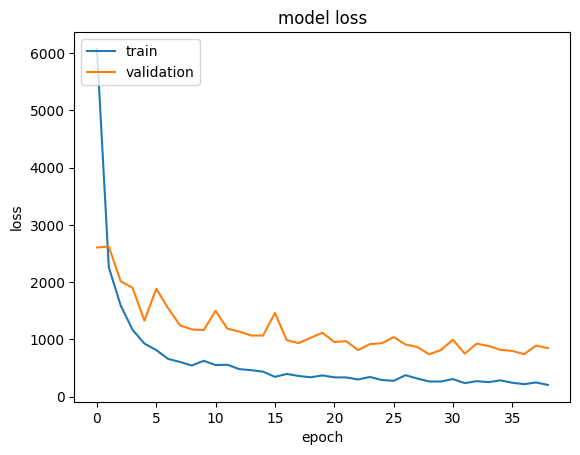

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.load_weights(weight_path)

In [ ]:
loss = model.evaluate(x=x_origin_test, y=y_test, batch_size=16)
print('RMSE is :', loss ** 0.5)

38/38 [==============================] - 3s 70ms/step - loss: 782.6961
RMSE is : 27.97670648873865


In [ ]:
y_predict = model.predict(x_origin_test)

19/19 [==============================] - 8s 192ms/step


In [ ]:
from sklearn.metrics import r2_score

r2_score(y_test, y_predict)

0.9569727347673553

In [ ]:
y_predict_pm25 = np.zeros(len(y_predict))

for i in range(len(y_predict)):
    if y_predict[i] <= 12.0:
        y_predict_pm25[i] = 0
    elif y_predict[i] <= 35.4:
        y_predict_pm25[i] = 1
    elif y_predict[i] <= 55.4:
        y_predict_pm25[i] = 2
    elif y_predict[i] <= 150.4:
        y_predict_pm25[i] = 3
    elif y_predict[i] <= 250.4:
        y_predict_pm25[i] = 4
    elif y_predict[i] > 250.4 :
        y_predict_pm25[i] = 5
    else:
        print('Exception Occured!')
    
y_predict_pm25 = y_predict_pm25.astype(int)
    
    
y_predict_pm25

array([5, 1, 1, 2, 1, 4, 1, 3, 3, 1, 2, 1, 5, 3, 4, 4, 1, 3, 4, 2, 2, 3,
       2, 3, 2, 3, 1, 1, 5, 5, 3, 3, 5, 2, 1, 1, 4, 1, 3, 4, 3, 1, 2, 1,
       5, 2, 2, 3, 5, 4, 1, 2, 5, 1, 3, 4, 5, 4, 5, 4, 5, 4, 1, 1, 5, 3,
       5, 5, 1, 0, 5, 1, 2, 4, 4, 1, 5, 1, 4, 1, 3, 3, 2, 1, 1, 2, 3, 1,
       2, 1, 5, 5, 5, 1, 5, 5, 4, 5, 3, 1, 1, 5, 4, 5, 5, 1, 4, 3, 1, 5,
       5, 5, 5, 1, 3, 5, 1, 1, 1, 3, 1, 3, 2, 1, 5, 2, 1, 1, 1, 5, 4, 1,
       1, 2, 5, 2, 5, 5, 4, 4, 1, 4, 5, 5, 4, 2, 4, 3, 4, 1, 1, 2, 2, 3,
       5, 1, 2, 3, 3, 1, 4, 4, 1, 1, 2, 1, 3, 3, 5, 3, 5, 1, 3, 1, 5, 5,
       1, 4, 1, 3, 4, 5, 5, 5, 5, 3, 2, 1, 5, 5, 5, 3, 1, 5, 1, 5, 5, 5,
       5, 1, 1, 5, 1, 3, 3, 3, 1, 3, 1, 1, 4, 2, 4, 4, 1, 1, 5, 5, 5, 4,
       4, 5, 5, 5, 1, 4, 5, 4, 1, 5, 5, 2, 0, 1, 1, 5, 5, 2, 5, 5, 2, 1,
       5, 5, 2, 4, 1, 5, 3, 3, 1, 5, 5, 3, 1, 4, 1, 1, 3, 4, 5, 1, 3, 1,
       5, 5, 5, 3, 1, 4, 3, 1, 4, 1, 5, 4, 5, 5, 1, 1, 5, 1, 3, 3, 3, 1,
       3, 5, 5, 1, 5, 1, 1, 1, 1, 5, 3, 1, 3, 1, 5,

In [ ]:
y_test = y_test.to_numpy().tolist()
y_test

In [ ]:
y_test[0]

257.0

In [ ]:
#Classify the Ground Truth PM25 concentration to the air quality levels

y_test_pm25 = np.zeros(len(y_test))

for i in range(len(y_test)):
    if int(y_test[i])  <= 50.0:
        y_test_pm25[i] = 0
    elif int(y_test[i]) <= 100.0:
        y_test_pm25[i] = 1
    elif int(y_test[i]) <= 250.0:
        y_test_pm25[i] = 2
    elif int(y_test[i]) <= 150.4:
        y_test_pm25[i] = 3
    elif int(y_test[i]) <= 250.4:
        y_test_pm25[i] = 4
    elif int(y_test[i]) > 250.5:
        y_test_pm25[i] = 5
    else:
        print('Exception Occured!')

y_test_pm25 = y_test_pm25.astype(int)
        
        
y_test_pm25

array([5, 1, 1, 1, 1, 4, 1, 3, 3, 1, 3, 1, 5, 3, 4, 4, 1, 3, 4, 2, 1, 3,
       2, 3, 2, 3, 1, 1, 5, 5, 3, 3, 5, 1, 1, 1, 5, 1, 3, 4, 3, 1, 2, 1,
       5, 1, 1, 3, 5, 4, 1, 2, 5, 1, 3, 4, 5, 4, 5, 4, 5, 4, 1, 1, 5, 3,
       3, 5, 1, 1, 5, 2, 2, 4, 4, 2, 5, 1, 4, 1, 3, 2, 1, 1, 1, 3, 3, 1,
       2, 1, 5, 5, 5, 2, 5, 5, 4, 5, 3, 1, 1, 5, 4, 5, 5, 1, 4, 3, 1, 5,
       5, 5, 5, 1, 3, 5, 1, 1, 1, 3, 1, 3, 2, 1, 5, 1, 1, 1, 1, 5, 4, 1,
       1, 2, 5, 2, 5, 5, 4, 4, 2, 5, 5, 5, 4, 2, 4, 3, 4, 1, 1, 2, 1, 3,
       5, 2, 2, 3, 3, 2, 3, 4, 1, 1, 2, 1, 3, 3, 5, 3, 5, 1, 3, 1, 5, 5,
       1, 3, 1, 3, 4, 5, 5, 5, 5, 3, 2, 1, 5, 5, 5, 3, 1, 5, 1, 5, 5, 5,
       5, 1, 1, 5, 1, 3, 3, 3, 1, 3, 1, 1, 4, 2, 4, 4, 1, 2, 5, 5, 5, 4,
       4, 5, 5, 5, 1, 4, 5, 4, 1, 5, 5, 2, 0, 1, 1, 5, 5, 1, 5, 5, 2, 1,
       5, 5, 2, 3, 1, 5, 3, 3, 1, 5, 5, 3, 1, 4, 1, 1, 3, 4, 5, 1, 3, 1,
       5, 5, 5, 3, 1, 4, 1, 1, 4, 1, 5, 4, 5, 5, 1, 1, 5, 1, 3, 3, 3, 1,
       3, 5, 5, 2, 5, 1, 1, 1, 1, 5, 3, 1, 3, 1, 5,

In [ ]:
#import Counter
from collections import Counter

#input list
input_list = y_predict_pm25

#keys of the dictionary will be the unique items 
print(Counter(input_list).keys())

#values will be the number of that key present in the list
print(Counter(input_list).values())

#new list with key-value pairs
print(Counter(input_list))

#count of unique values
print("Count- ", len(Counter(input_list)))

dict_keys([3, 0, 2, 1, 4, 5])
dict_values([95, 236, 91, 112, 52, 14])
Counter({0: 236, 1: 112, 3: 95, 2: 91, 4: 52, 5: 14})
Count-  6


In [ ]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test_pm25, y_predict_pm25)

0.7735255909104901

In [ ]:
#---Classification Accuracy for PM2.5---------

# t = 0
# n = 0

# for i in range(len(y_predict_pm10)):
#     if y_predict_pm10[i] == y_test_pm10[i]:
#         t = t + 1
#     else:
#         n = n + 1
        
# acc = t / len(y_predict_pm10)

# print('Acc: ', acc, ' True: ', t, ' False: ', n)

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_test_pm25, y_predict_pm25, average='macro')

0.7749540894685759

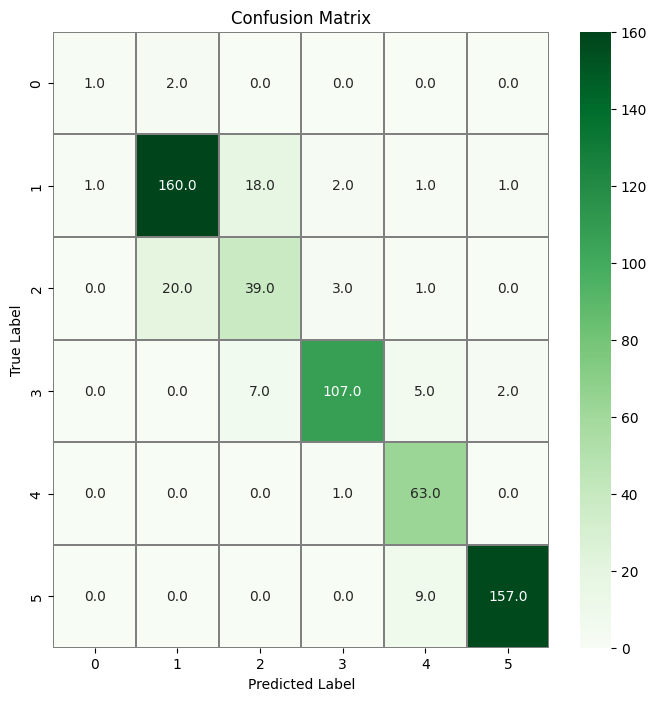

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
Y_pred_classes = y_predict_pm25
Y_true = y_test_pm25
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

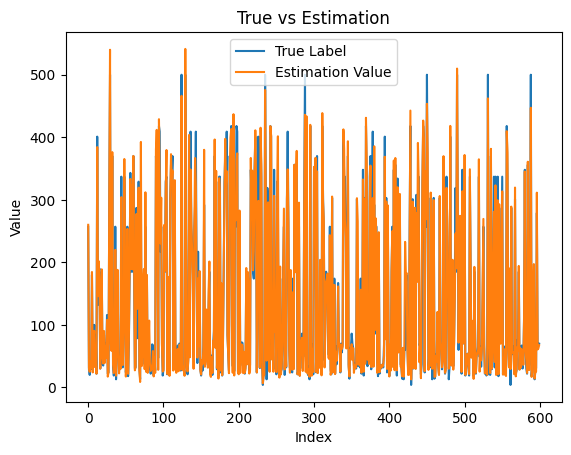

In [ ]:
plt.plot(y_test, label='True Label')
plt.plot(y_predict, label='Estimation Value')

# set the x-axis label
plt.xlabel('Index')

# set the y-axis label
plt.ylabel('Value')

# set the plot title
plt.title('True vs Estimation')

# Adding a legend
plt.legend()

# display the plot
plt.show()

In [ ]:
import os
file_name = "/content/EfficientNetV2L_aqi.best.hdf5"

file_stats = os.stat(file_name)

print(file_stats)
print(f'File Size in Bytes is {file_stats.st_size}')
print(f'File Size in MegaBytes is {file_stats.st_size / (1024 * 1024)}')

os.stat_result(st_mode=33188, st_ino=2134073, st_dev=46, st_nlink=1, st_uid=0, st_gid=0, st_size=211964968, st_atime=1684170053, st_mtime=1684169812, st_ctime=1684169812)
File Size in Bytes is 211964968
File Size in MegaBytes is 202.14554595947266
